# Facial Skin Color Correction

This code is divided into the following sections:

1. Libraries and Auxiliary Functions
2. Detection and Extraction of Regions of Interest (ROI)
3. Color Grading
4. Bilater Filter
5. Evaluation and Testing

## 1. Libraries and Auxiliary Functions

This section imports necessary libraries and defines helper functions for tasks like image manipulation and displaying images.


In [8]:
import cv2 as cv
import numpy as np
import mediapipe as mp # python [3.8 ~ 3.11]
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import math
from PIL import Image, ImageDraw, ImageTk

DESIRED_HEIGHT = 800
DESIRED_WIDTH = 800

# function to display images using matplotlib
def show_plot(image, title="Image"):
    img = resize_img(image)

    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

# function to resize images
def resize_img(image):
    h, w = image.shape[:2]
    if h < w:
        img = cv.resize(image, (DESIRED_WIDTH, int(h/(w/DESIRED_WIDTH))))
    else:
        img = cv.resize(image, (int(w/(h/DESIRED_HEIGHT)), DESIRED_HEIGHT))
    return img

# function to plot all tones in one grid
def plot_grid(images_by_column, titles_row, figsize=(20, 10)):
    rows = len(titles_row)
    cols = len(images_by_column)
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    for col_idx, images in enumerate(images_by_column):
        for row_idx, img in enumerate(images):
            ax = axes[row_idx, col_idx] if rows > 1 else axes[col_idx]
            ax.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
            ax.axis('off')
            if row_idx == 0:
                ax.set_title(f"Tone {col_idx+1}", fontsize=12)
    
    # add row labels on the left
    for row_idx, title in enumerate(titles_row):
        axes[row_idx, 0].annotate(title, xy=(-0.1, 0.5), xycoords="axes fraction",
                                  fontsize=12, ha="center", va="center", rotation=90)
    plt.tight_layout()
    plt.show()

## 2. Detection and Extraction of Regions of Interest (ROI)

Uses mediapipe to detect facial landmarks and extracts key facial areas (forehead, cheeks) or the human face for skin color correction.

I0000 00:00:1733939399.124334    9938 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733939399.127627   11908 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.8), renderer: AMD Radeon RX 5500 XT (radeonsi, navi14, LLVM 19.1.0, DRM 3.59, 6.11.10-300.fc41.x86_64)
W0000 00:00:1733939399.137226   11904 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733939399.147361   11903 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733939399.246522    9938 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733939399.249131   11916 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.8), renderer: AMD Radeon RX 5500 XT (radeonsi, navi14, LLVM 19.1.0, DRM 3.59, 6.11.10-300.fc41.x86_64)
W0000 00:00:1733

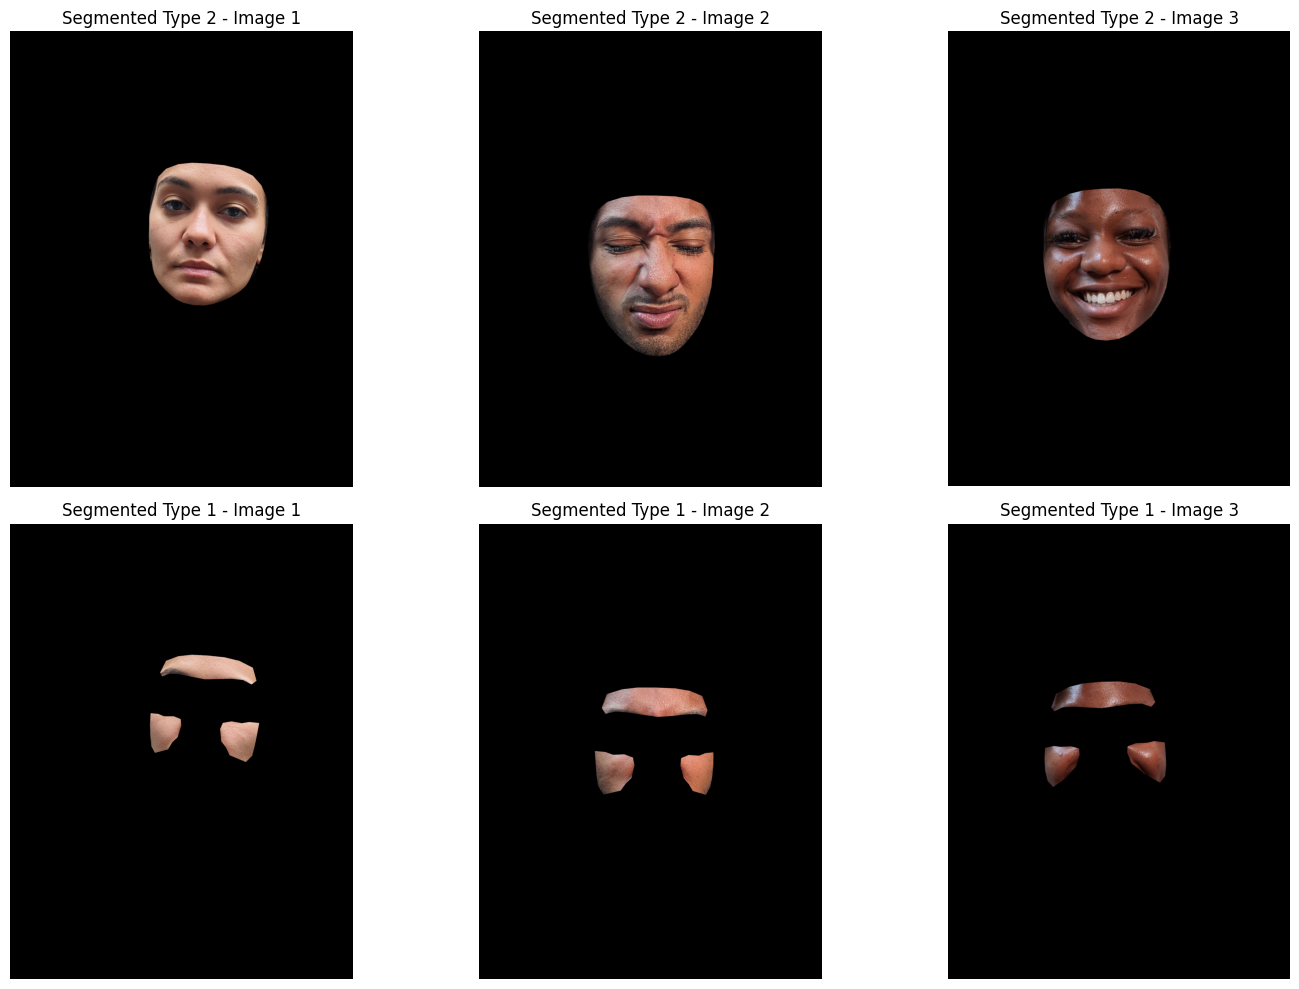

In [9]:
# regions of interest (roi)
forehead = [10,338,297,332,298,293,334,296,336,9,107,66,105,63,68,103,67,109,10]
left_cheek= [116,117,118,119,100,142,203,206,216,192,213,147,123,116]
right_cheek = [345,346,347,348,329,371,423,426,436,416,433,376,352,345]
face = [10,338,297,332,284,251,389,356,454,323,361,288,397,365,379,378,400,377,152,148,176,149,150,136,172,58,132,93,234,127,162,21,54,103,67,109,10]

# selection of the regions of interest (roi)
def region_of_interest_segmentation(roi, info, img):
    imArray = np.asarray(img)

    polygon = []
    for i in range(len(roi)):
        idx_s = roi[i]
        start_point = (info[idx_s][3], info[idx_s][4])
        polygon.append(start_point)

    maskIm = Image.new('L', (imArray.shape[1], imArray.shape[0]), 0)
    ImageDraw.Draw(maskIm).polygon(polygon, outline=1, fill=1)
    mask = np.array(maskIm)

    newImArray = np.zeros(img.shape, dtype='uint8')

    newImArray[:,:,0] = np.multiply(imArray[:,:,0], mask)
    newImArray[:,:,1] = np.multiply(imArray[:,:,1], mask)
    newImArray[:,:,2] = np.multiply(imArray[:,:,2], mask)

    return newImArray, mask

# function to segmentation an input image
def segmentation(image, type = 2):
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces = 1, min_detection_confidence=0.5)

    results = face_mesh.process(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    landmarks = results.multi_face_landmarks[0]

    shape_a = image.shape[1]
    shape_b = image.shape[0]
    info = []

    for landmark in landmarks.landmark:
        x = landmark.x
        y = landmark.y
        z = landmark.z

        relative_x = int(shape_a * x)
        relative_y = int(shape_b * y)

        info.append([x,y,z,relative_x,relative_y])

    # roi = forehead + left_cheek + right_cheek
    if type == 1:
        img1,_ = region_of_interest_segmentation(forehead, info, image)
        img2,_ = region_of_interest_segmentation(left_cheek, info, image)
        img3,_ = region_of_interest_segmentation(right_cheek, info, image)
        regions_interest = np.maximum(np.maximum(img1, img2), img3)

    # roi = face
    if type == 2:
        img1,_ = region_of_interest_segmentation(face, info, image)
        regions_interest = img1

    return regions_interest

# input images
image_paths = ['img/in/golden_pics_mst/skin_tone_4/img1.jpg', 
               'img/in/golden_pics_mst/skin_tone_6/img2.jpg', 
               'img/in/golden_pics_mst/skin_tone_8/img2.jpg']

segmented_images_type1 = []
segmented_images_type2 = []

for image_path in image_paths:
    img_input = cv.imread(image_path)
    
    # segmented images type 2 (face)
    roi_input_type2 = cv.cvtColor(segmentation(img_input, 2), cv.COLOR_BGR2RGB)
    segmented_images_type2.append(roi_input_type2)
    
    # segmented images type 1 (forehead, cheeks)
    roi_input_type1 = cv.cvtColor(segmentation(img_input, 1), cv.COLOR_BGR2RGB)
    segmented_images_type1.append(roi_input_type1)

# plots
fig, axes = plt.subplots(2, len(segmented_images_type1), figsize=(15, 10))

for i, ax in enumerate(axes[0]):
    ax.imshow(segmented_images_type2[i])
    ax.axis('off')  
    ax.set_title(f"Segmented Type 2 - Image {i+1}")  

for i, ax in enumerate(axes[1]):
    ax.imshow(segmented_images_type1[i])
    ax.axis('off') 
    ax.set_title(f"Segmented Type 1 - Image {i+1}")  

plt.tight_layout()  
plt.show()

## 3. Color Grading

Applies a color correction algorithm to adjust the skin tones of the extracted regions, matching them to a reference color palette.

Processing img/in/mst_input/skin_tone_4/img3.jpg and img/in/golden_pics_mst/skin_tone_4/img1.jpg


I0000 00:00:1733940308.581971    9938 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733940308.583881   14178 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.8), renderer: AMD Radeon RX 5500 XT (radeonsi, navi14, LLVM 19.1.0, DRM 3.59, 6.11.10-300.fc41.x86_64)
W0000 00:00:1733940308.590314   14172 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733940308.602043   14174 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733940308.632676    9938 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733940308.635273   14186 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.8), renderer: AMD Radeon RX 5500 XT (radeonsi, navi14, LLVM 19.1.0, DRM 3.59, 6.11.10-300.fc41.x86_64)
W0000 00:00:1733

Processing img/in/mst_input/skin_tone_2/img8.jpg and img/in/golden_pics_mst/skin_tone_2/img2.jpg


I0000 00:00:1733940313.008320    9938 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733940313.010612   14198 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.8), renderer: AMD Radeon RX 5500 XT (radeonsi, navi14, LLVM 19.1.0, DRM 3.59, 6.11.10-300.fc41.x86_64)
W0000 00:00:1733940313.017863   14192 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733940313.029136   14194 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733940313.048894    9938 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733940313.050620   14206 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.8), renderer: AMD Radeon RX 5500 XT (radeonsi, navi14, LLVM 19.1.0, DRM 3.59, 6.11.10-300.fc41.x86_64)
W0000 00:00:1733

Processing img/in/mst_input/skin_tone_8/img9.jpg and img/in/golden_pics_mst/skin_tone_8/img2.jpg


I0000 00:00:1733940317.411062    9938 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733940317.413430   14219 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.8), renderer: AMD Radeon RX 5500 XT (radeonsi, navi14, LLVM 19.1.0, DRM 3.59, 6.11.10-300.fc41.x86_64)
W0000 00:00:1733940317.425421   14213 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733940317.435728   14212 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733940317.456921    9938 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733940317.459746   14227 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.8), renderer: AMD Radeon RX 5500 XT (radeonsi, navi14, LLVM 19.1.0, DRM 3.59, 6.11.10-300.fc41.x86_64)
W0000 00:00:1733

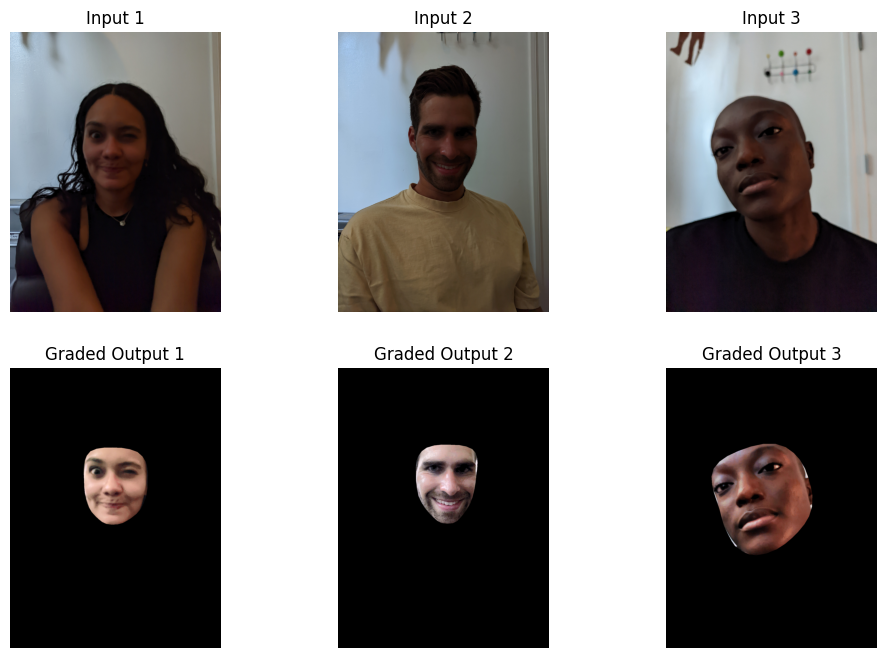

In [12]:
# color_grading - iterative distribution transfer (IDT) algorithm
def color_grading_idt(img1, img2, bins=300, n_rot=10, relaxation=1):

    n_dims = img1.shape[1]

    d1 = img1.T
    d2 = img2.T

    for i in range(n_rot):
        # generate a random orthogonal rotation matrix
        rot = sp.stats.special_ortho_group.rvs(n_dims).astype(np.float32)

        d1r = np.dot(rot, d1)
        d2r = np.dot(rot, d2)
        d_r = np.empty_like(d1)

        # perform the histogram matching for each dimension separately
        for j in range(n_dims):

            # filter out NaN values from the rotated datasets
            valid_d1r = d1r[j][~np.isnan(d1r[j])]
            valid_d2r = d2r[j][~np.isnan(d2r[j])]

            if len(valid_d1r) == 0 or len(valid_d2r) == 0:
                continue

            lo = min(valid_d1r.min(), valid_d2r.min())
            hi = max(valid_d1r.max(), valid_d2r.max())

            # compute histograms and cumulative distributions (CDF) for both datasets
            p1r, edges = np.histogram(valid_d1r, bins=bins, range=[lo, hi])
            p2r, _ = np.histogram(valid_d2r, bins=bins, range=[lo, hi])

            cp1r = p1r.cumsum().astype(np.float32)
            cp1r /= cp1r[-1]

            cp2r = p2r.cumsum().astype(np.float32)
            cp2r /= cp2r[-1]

            f = np.interp(cp1r, cp2r, edges[1:])

            d_r[j] = np.interp(d1r[j], edges[1:], f, left=lo, right=hi)

        d1 = relaxation * np.linalg.solve(rot, (d_r - d1r)) + d1

    return d1.T

# function to correct color grading
def correct(input_paths, target_paths):
    plt.figure(figsize=(12, 8))
    corrected_images = []

    for i, (path_input, path_target) in enumerate(zip(input_paths, target_paths)):
        print(f"Processing {path_input} and {path_target}")

        img_input = cv.imread(path_input)
        img_target = cv.imread(path_target)

        # resizing the images for optimization
        width = int(img_input.shape[1] * 40 / 100)
        height = int(img_input.shape[0] * 40 / 100)
        dim = (width, height)

        img_target = cv.resize(img_target, dim)
        img_input = cv.resize(img_input, dim)

        # segmentation of the regions of interest (roi)
        roi_input = cv.cvtColor(segmentation(img_input, 2), cv.COLOR_BGR2RGB)
        roi_target = cv.cvtColor(segmentation(img_target, 2), cv.COLOR_BGR2RGB)

        # creation of DataFrames
        df_roi_ipt = pd.DataFrame(roi_input.reshape(-1, roi_input.shape[-1]), columns=['r', 'g', 'b'])
        df_roi_tgt = pd.DataFrame(roi_target.reshape(-1, roi_target.shape[-1]), columns=['r', 'g', 'b'])

        # turning all black pixels into NaN
        df_roi_ipt_nan = df_roi_ipt.mask((df_roi_ipt[['r', 'g', 'b']] == 0).all(axis=1))
        df_roi_tgt_nan = df_roi_tgt.mask((df_roi_tgt[['r', 'g', 'b']] == 0).all(axis=1))

        a_input = df_roi_ipt_nan.values
        a_target = df_roi_tgt_nan.values

        # applying color grading
        a_result = color_grading_idt(a_input, a_target, bins=300, n_rot=20, relaxation=1)

        # converting the result back to a DataFrame and reshaping to the original image shape
        df_result = pd.DataFrame(a_result, columns=['r', 'g', 'b'])
        img_output = a_result.reshape(roi_input.shape)

        # converting the image to absolute scale and changing the color format from RGB to BGR
        img_output = cv.convertScaleAbs(img_output)
        img_output = cv.cvtColor(img_output, cv.COLOR_RGB2BGR)

        corrected_images.append(img_output)

        # Plotting the images

        # Plot input image
        plt.subplot(2, len(input_paths), i + 1)
        plt.imshow(cv.cvtColor(img_input, cv.COLOR_BGR2RGB))
        plt.title(f"Input {i + 1}")
        plt.axis('off')

        # Plot color graded image
        plt.subplot(2, len(input_paths), len(input_paths) + i + 1)
        plt.imshow(cv.cvtColor(img_output, cv.COLOR_BGR2RGB))
        plt.title(f"Graded Output {i + 1}")
        plt.axis('off')

    return corrected_images

    plt.tight_layout()
    plt.show()

# example usage
input_paths = ['img/in/mst_input/skin_tone_4/img3.jpg', 
               'img/in/mst_input/skin_tone_2/img8.jpg', 
               'img/in/mst_input/skin_tone_8/img9.jpg']

target_paths = ['img/in/golden_pics_mst/skin_tone_4/img1.jpg', 
                'img/in/golden_pics_mst/skin_tone_2/img2.jpg', 
                'img/in/golden_pics_mst/skin_tone_8/img2.jpg']

corrected_images = correct(input_paths, target_paths)

## 4. Bilateral Filter

This section applies a bilateral filter to the image, which is commonly used for smoothing images while preserving edges. The changes are subtle, but they help reduce noise.

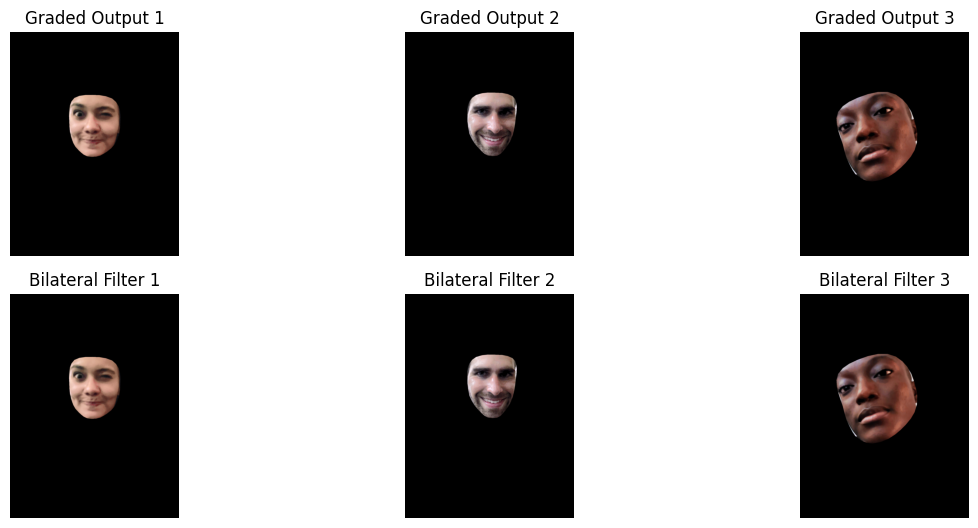

In [ ]:
# function to apply bilateral filter
def apply_bilateral(img):
    face_area = np.count_nonzero(img)  
    total_area = img.shape[0] * img.shape[1]
    face_ratio = face_area / total_area

    # dynamic parameters
    d = max(5, int(15 * face_ratio))  # windows size
    sigma_color = 50 + int(50 * face_ratio)  
    sigma_space = 50 + int(50 * face_ratio)  

    # bilateral filter
    filtered_img = cv.bilateralFilter(img, d, sigma_color, sigma_space)

    return filtered_img

# Plot 
plt.figure(figsize=(12, 8))

for i, (path_input, img_output) in enumerate(zip(input_paths, corrected_images)):
    img_input = cv.imread(path_input)
    
    # bilateral filtering
    img_bilateral = apply_bilateral(img_output)
    
    plt.subplot(3, len(input_paths), i + 1)
    plt.imshow(cv.cvtColor(img_output, cv.COLOR_BGR2RGB))
    plt.title(f"Graded Output {i + 1}")
    plt.axis('off')

    plt.subplot(3, len(input_paths), len(input_paths) + i + 1)
    plt.imshow(cv.cvtColor(img_bilateral, cv.COLOR_BGR2RGB))
    plt.title(f"Bilateral Filter {i + 1}")
    plt.axis('off')

    cv.imwrite(f"img/out/bilateral_filter/img_out_{i}.jpg", img_output)
    cv.imwrite(f"img/out/bilateral_filter/img_bi_{i}.jpg", img_bilateral)
    


plt.tight_layout()
plt.show()


## 5. Evaluation and Testing

Tests the color correction process by comparing the results to a reference and evaluating the effectiveness of the algorithm.

I0000 00:00:1733939099.075170    9938 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733939099.077040   11069 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.8), renderer: AMD Radeon RX 5500 XT (radeonsi, navi14, LLVM 19.1.0, DRM 3.59, 6.11.10-300.fc41.x86_64)
W0000 00:00:1733939099.082814   11063 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1733939099.097398   11065 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1733939099.129696    9938 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1733939099.131982   11077 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 24.2.8), renderer: AMD Radeon RX 5500 XT (radeonsi, navi14, LLVM 19.1.0, DRM 3.59, 6.11.10-300.fc41.x86_64)
W0000 00:00:1733

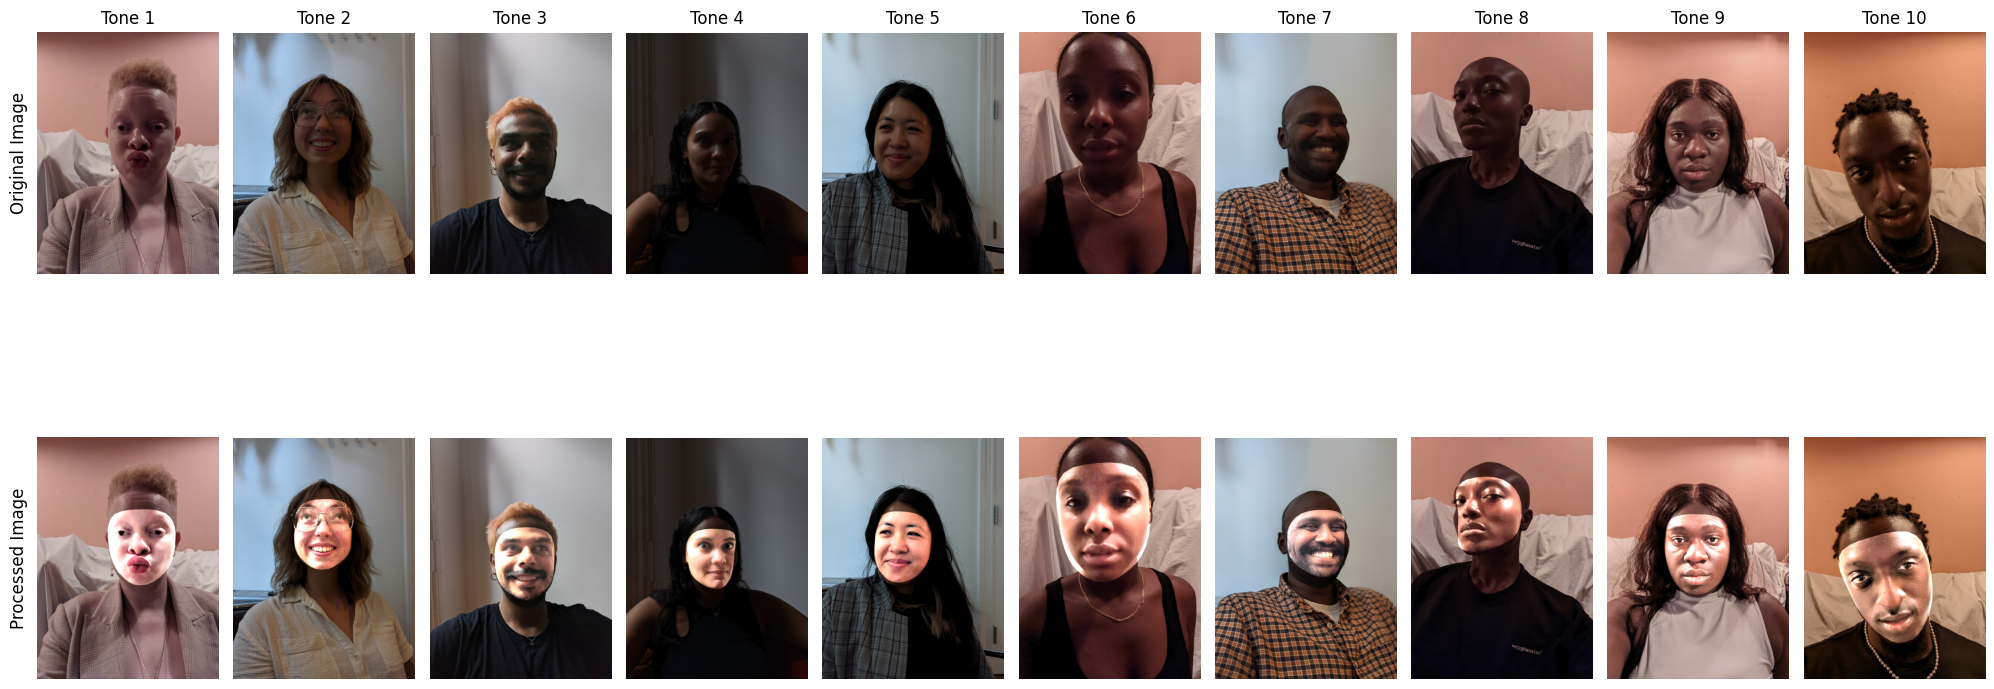

In [ ]:
# Main program
images_by_column = []  # To store images for each tone (columns)
titles_row = ["Original Image", "Processed Image"]  # Row titles

for i in range(1,11):
    path_input = f"img/in/mst_input/skin_tone_{i}/img1.jpg"
    path_target = f"img/in/golden_pics_mst/skin_tone_{i}/img1.jpg"

    img_input = cv.imread(path_input)
    img_target = cv.imread(path_target)

    # Resizing the images for optimization
    width = int(img_input.shape[1] * 40 / 100)
    height = int(img_input.shape[0] * 40 / 100)
    dim = (width, height)

    img_input = cv.resize(img_input, dim)
    img_target = cv.resize(img_target, dim)

    # segmentation of the regions of interest (roi)
    roi_input = cv.cvtColor(segmentation(img_input,2), cv.COLOR_BGR2RGB)
    roi_target = cv.cvtColor(segmentation(img_target,2), cv.COLOR_BGR2RGB)

    # creation of Dataframes
    df_roi_ipt = pd.DataFrame(roi_input.reshape(-1, roi_input.shape[-1]), columns=['r', 'g', 'b'])
    df_roi_tgt = pd.DataFrame(roi_target.reshape(-1, roi_target.shape[-1]), columns=['r', 'g', 'b'])

    # turning all black pixels into NaN
    df_roi_ipt_nan = df_roi_ipt.mask((df_roi_ipt[['r', 'g', 'b']] == 0).all(axis=1))
    df_roi_tgt_nan = df_roi_tgt.mask((df_roi_tgt[['r', 'g', 'b']] == 0).all(axis=1))

    a_input = df_roi_ipt_nan.values
    a_target = df_roi_tgt_nan.values

    # applying color grading
    a_result = color_grading_idt(a_input, a_target, bins=300, n_rot=20, relaxation=1)
    
    # converting the result back to an image
    img_output = a_result.reshape(img_input.shape)
    img_output = cv.convertScaleAbs(img_output)
    img_output = cv.cvtColor(img_output, cv.COLOR_RGB2BGR)

    # final processing
    img_bilateral = apply_bilateral(img_output)
    img_final = cv.add(img_input, img_bilateral)

    # append images to the column
    images_by_column.append([img_input, img_final])

# plot all tones in a grid
plot_grid(images_by_column, titles_row)
